# Keras InceptionV1 classifier for CIFAR10 test
GoogleInceptionV1 network for CIFAR10 network test

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from data_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import tensorflow as tf 
from keras import backend as k
import os
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth = True
k.tensorflow_backend.set_session(tf.Session(config=config))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# get data
cifar10_data = CIFAR10Data()
x_train, y_train, x_test, y_test = cifar10_data.get_data(subtract_mean=True)

num_train = int(x_train.shape[0] * 0.8)
num_val = x_train.shape[0] - num_train
mask = list(range(num_train, num_train+num_val))
x_val = x_train[mask]
y_val = y_train[mask]

mask = list(range(num_train))
x_train = x_train[mask]
y_train = y_train[mask]
print(x_train.shape)

CIFAR10 Training data shape: (50000, 32, 32, 3)
CIFAR10 Training label shape (50000, 1)
CIFAR10 Test data shape (10000, 32, 32, 3)
CIFAR10 Test label shape (10000, 1)
(40000, 32, 32, 3)


In [23]:
from classifiers.GoogLeNet import InceptionV1ForCIFAR10
from keras import losses

weight_decay = 5e-4
lr = 1e-1
num_classes = 10
inceptionV1 = InceptionV1ForCIFAR10(input_shape=(32, 32, 3), classes=num_classes, weight_decay=weight_decay)
opt = keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=False)
inceptionV1.compile(optimizer=opt,
                    loss=losses.categorical_crossentropy,
                    metrics=['accuracy'])
inceptionV1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
2a-conv (Conv2D)                (None, 32, 32, 64)   192         input_7[0][0]                    
__________________________________________________________________________________________________
2a-bn (BatchNormalization)      (None, 32, 32, 64)   192         2a-conv[0][0]                    
__________________________________________________________________________________________________
2a-relu (Activation)            (None, 32, 32, 64)   0           2a-bn[0][0]                      
__________________________________________________________________________________________________
2b-conv (C

In [24]:
%%time
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
# fit data with data augmentation or not
data_augmentation = True


def lr_scheduler(epoch):
    return lr * (0.1 ** (epoch // 30))

reduce_lr = LearningRateScheduler(lr_scheduler)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=10, min_lr=1e-6, verbose=1)

batch_size = 128
epochs = 120

if data_augmentation:
    # datagen
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False, # randomly flip images
    ) 
    # (std, mean, and principal components if ZCA whitening is applied).
    # datagen.fit(x_train)
    print('train with data augmentation')
    history = inceptionV1.fit_generator(generator=datagen.flow(x_train, y_train, batch_size=batch_size),
                                        epochs=epochs,
                                        callbacks=[reduce_lr],
                                        validation_data=(x_val, y_val)
                                        )
else:
    print('train without data augmentation')
    history = inceptionV1.fit(x_train, y_train, 
                      batch_size=batch_size, epochs=epochs, 
                      callbacks=[reduce_lr],
                      validation_data=(x_val, y_val)
                      )

train with data augmentation
Epoch 1/120
313/313 [==============================] - 122s 389ms/step - loss: 5.5466 - acc: 0.3065 - val_loss: 7.7617 - val_acc: 0.1782
Epoch 2/120
313/313 [==============================] - 92s 293ms/step - loss: 3.5517 - acc: 0.4635 - val_loss: 3.3966 - val_acc: 0.3298
Epoch 3/120
313/313 [==============================] - 93s 298ms/step - loss: 2.3949 - acc: 0.5610 - val_loss: 2.7584 - val_acc: 0.3748
Epoch 4/120
313/313 [==============================] - 93s 298ms/step - loss: 1.7846 - acc: 0.6243 - val_loss: 2.0664 - val_acc: 0.4778
Epoch 5/120
313/313 [==============================] - 94s 301ms/step - loss: 1.4322 - acc: 0.6753 - val_loss: 2.3045 - val_acc: 0.4869
Epoch 6/120
313/313 [==============================] - 94s 300ms/step - loss: 1.2000 - acc: 0.7177 - val_loss: 1.6989 - val_acc: 0.5649
Epoch 7/120
313/313 [==============================] - 96s 306ms/step - loss: 1.0670 - acc: 0.7493 - val_loss: 1.5183 - val_acc: 0.6325
Epoch 8/120
313/31

313/313 [==============================] - 93s 296ms/step - loss: 0.2246 - acc: 0.9691 - val_loss: 0.5268 - val_acc: 0.8911
Epoch 61/120
313/313 [==============================] - 92s 294ms/step - loss: 0.1985 - acc: 0.9788 - val_loss: 0.3755 - val_acc: 0.9284
Epoch 62/120
313/313 [==============================] - 93s 296ms/step - loss: 0.1751 - acc: 0.9880 - val_loss: 0.3908 - val_acc: 0.9260
Epoch 63/120
313/313 [==============================] - 93s 297ms/step - loss: 0.1678 - acc: 0.9903 - val_loss: 0.3656 - val_acc: 0.9316
Epoch 64/120
313/313 [==============================] - 93s 297ms/step - loss: 0.1637 - acc: 0.9911 - val_loss: 0.3711 - val_acc: 0.9318
Epoch 65/120
313/313 [==============================] - 94s 301ms/step - loss: 0.1604 - acc: 0.9921 - val_loss: 0.3723 - val_acc: 0.9318
Epoch 66/120
313/313 [==============================] - 94s 301ms/step - loss: 0.1574 - acc: 0.9928 - val_loss: 0.3760 - val_acc: 0.9311
Epoch 67/120
313/313 [==============================] 

Epoch 120/120
313/313 [==============================] - 92s 295ms/step - loss: 0.1183 - acc: 0.9988 - val_loss: 0.3689 - val_acc: 0.9370
CPU times: user 2h 55min 12s, sys: 20min 6s, total: 3h 15min 18s
Wall time: 3h 9min 31s


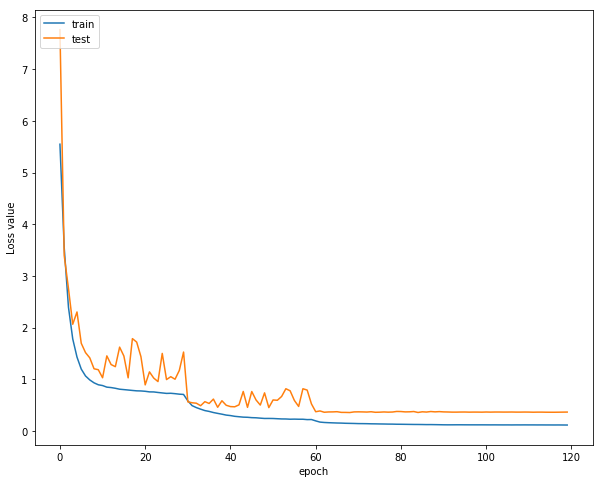

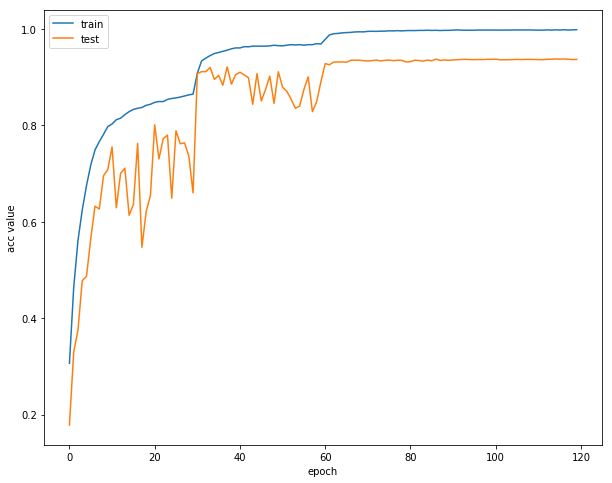

In [25]:
# plot loss and acc 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
loss, acc = inceptionV1.evaluate(x_test, y_test)
print('evaluate loss:%f acc:%f' % (loss, acc))

10000/10000 [==============================] - 13s 1ms/step
evaluate loss:0.397236 acc:0.930800
